In [1]:
#!/usr/bin/env python3

"""
Numerical solution and optimization of ballistic trajectories with drag

This module provides funtions:
- to model the trajectory of an object, given its parameters and start 
  values, 
- to optimize one or two of its parameters within a given range with a 
  given stepsize,
- to plot (the resulting) relations in a (2 or 3-dimensional) plot.

How to use this module:
- either call the function demo() to see a short demonstration of the 
  functionalities
- or call the separate functions manually with your own parameters
    
For examples on how to call the functions see the demo() function.
    

File name: waterrocket.ipynb / waterrocket.py
Author: Paul Eckstein
Date created: 27/1/2018
Date last modified: 5/4/2018
Python Version: 3.6.4
"""

'\nNumerical solution and optimization of ballistic trajectories with drag\n\nThis module provides funtions:\n- to model the trajectory of an object, given its parameters and start \n  values, \n- to optimize one or two of its parameters within a given range with a \n  given stepsize,\n- to plot (the resulting) relations in a (2 or 3-dimensional) plot.\n\nHow to use this module:\n- either call the function demo() to see a short demonstration of the \n  functionalities\n- or call the separate functions manually with your own parameters\n    \nFor examples on how to call the functions see the demo() function.\n    \n\nFile name: waterrocket.ipynb / waterrocket.py\nAuthor: Paul Eckstein\nDate created: 27/1/2018\nDate last modified: 5/4/2018\nPython Version: 3.6.4\n'

In [2]:
# Import built-in modules
import sys
import unicodedata

In [3]:
# Warn if Python version is not Python3
if sys.version[0] != '3':
    print('Please use Python 3')
    exit()

# Check if run in IPython or Python (Tom Dunham stackoverflow.com/a/5377051)
def ipy():
    try:
        __IPYTHON__
        return True
    except NameError:
        return False

# Check if run in Jupyter Notebook, IPython or Python 
# (Gustavo Bezerra stackoverflow.com/a/39662359)
def isnb():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [4]:
# Import third-party modules
from scipy import special, optimize
import numpy as np

# Because %matplotlib inline only works in Jupyter Notebook
if isnb():
    %matplotlib inline
elif ipy():
    %matplotlib auto

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# To suppress futurewarning from ...: (remove if source of warning not found)
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Define the loadingbar function (jelde015 stackoverflow.com/a/47077459)
def loadingBar(count, total, size, ch='='):
    percent = float(count) / float(total)
    # Check if run within Juptyer Notebook, because it handles displays wide 
    # unicode characters in two cells, so no correction needed.
    if isnb():
        sys.stdout.write('\r' + str(int(count)).rjust(3, '0') + '/' + 
                         str(int(total)).rjust(3, '0') + 
                         ' [' + ch*int(percent*size) + 
                         '  '*(size - int(percent*size)) + ']')
    # If not in Jupyter NB, but character needs more than one cell, append a 
    # space to prevent overlap.
    elif unicodedata.east_asian_width(ch) == 'W':
        sys.stdout.write('\r' + str(int(count)).rjust(3, '0') + '/' + 
                         str(int(total)).rjust(3, '0') + 
                         ' [' + (ch+' ')*int(percent*size) + 
                         '  '*(size - int(percent*size)) + ']')

In [6]:
# Declaring of default values of parameters
modulemode = True  # Indicate that the script is being used as a module
figindex = 0       # Index for creating separate figures
save_figs = False  # Whether to save the plots (into same directory as script)
step = 0.05        # Stepsize for plotting graphs      [m]

r = 0.04           # Radius of rocket                  [m]
cw = 0.4           # Drag coefficient                  [0]
rho = 1.225        # Air density                       [kg/m^3]
m = 0.072          # Mass of rocket                    [kg]
alpha = np.deg2rad(45)  # Launch angle                 [rad]
g = 9.81           # Gravitational acceleration        [m/s^2]

thrust = 2.5       # Constant to simulate thrust to establish relationship 
                   # between launch speed and mass.

# Initialize dictionary of all parameters used in the equations
parameters = {'rho': rho, 'cw': cw, 'r': r, 
              'thrust': thrust, 'alpha': alpha,
              'm': m, 'g': g}
# Make a pretty version of the parameter dictionary for use in the demo fuction
nice_prm = {'Air density (kg/m^3)': rho, 
            'Drag coefficient (0)': cw, 
            'Rocket radius (m)': r, 
            'Thrust simulation constant (...)': thrust, 
            'Launch angle (deg)': np.rad2deg(alpha), 
            'Empty rocket mass (kg)': m, 
            'Gravitational acceleration (m/s^2)': g}
# Dictionary for default parameters of a subplot for the plot_sub() function
default = {'equal': 0,
           'title': [''],
           'xlabel': [''],
           'ylabel': ['']}

In [7]:
def form(prm):
    """
    This function is used by other functions to update the formulas with 
    adjusted parameters for optimization and it accepts a dictionary of 
    all required parameters in the following form:
        {'rho': rho,
         'cw': cw,
         'r': r,
         'thrust': thrust,
         'alpha': alpha,
         'm': m,
         'g': g}
    Here you can substitute the current variables with your own values.
    
    The function returns the functions for the horizontal and vertical 
    distance depending on time.
    """
    # unpack new parameters
    rho, cw, r, thrust, alpha, m, g = prm.values()
    # Constant c contains all constants from equation for deceleration
    # due to air resistance.
    c = (rho*cw*np.pi*r**2)/(2*m)
    # Constants mx and my offset function to go through (0,0)
    mx = -1/(c*thrust*np.cos(alpha)/m)
    my = -1/(c*thrust*np.sin(alpha)/m)
    # Redefine functions, now with updated parameters
    def sx(t): return np.log(np.abs(1 - t/mx))/c
    def sy(t): return np.log(np.abs(1 - t/my))/c - (g*t**2)/2
    
    return(sx,sy)

In [8]:
def stepresize(lower_bound, upper_bound, stepsize):
    """
    This function makes it possible to enter rational stepsizes into
    functions to achieve better precision. To do so, it scales the 
    stepsize to 1 and then scales the bounds accordingly.
    Only rational stepsizes where the numerator = 1 such as 
    1/2, 1/3 ... 1/n will work.
    If the stepsize is a whole number the function will output 
    everyting unchanged.
    
    When used to scale the bounds and stepsizes for a 
    'for x in range(...)'-loop, the iterator (in this case x) has to be 
    multiplied with the scale factor to get the actual value of the 
    parameter.    
    
    The function returns in order:
    - the new upper bound
    - the new lower bound
    - the new stepsize
    - the scale factor with which the bounds have been scaled.
    """
    # check if stepsize is a fraction
    if stepsize < 1:
        if (1/stepsize).is_integer():
            step_out = 1
            low_out = int(lower_bound/stepsize)  # Scale bounds accordingly
            high_out = int(upper_bound/stepsize)
            scale = stepsize
        else:
            raise ValueError('Step is not rational stepsize like 1/2 ... 1/n')
    elif not float(stepsize).is_integer():
        raise ValueError('Step is not integer stepsize like 1, 2, 3, 4 ...')
    # if stepsize is integer and >=1, use it directly
    else:
        step_out = stepsize
        low_out = lower_bound
        high_out = upper_bound
        scale = 1
    return(low_out, high_out, step_out, scale)

In [9]:
def opt(lo, hi, st, vary, prm):
    """ 
    This function can be used to optimize a variable you specify through
    vary, within the range between lo and hi with stepsize st. The 
    function does accept rational numbers as inputs for lo, hi and st,
    though make sure to use a combination of lo, hi and st where lo and
    hi divided by st form an integer. This is to ensure that the 
    range()-function works. Also make sure that vary is a key in the 
    dictionary prm. Make sure to pass only a copy of the dictionary to 
    the function, because values inside the dictionary will get changed.
    By passing only an independent copy the original dictionary will 
    stay intact.
    
    The function returns in order:
    - a list of values of the variable used, 
    - a list of the distances achieved for the respective value of the 
      variable
    - the value of the variable which resulted in the greatest distance
      being achieved
    """
    if not (vary in [*prm]):
        raise ValueError('Invalid variable')

    var=[]    # List to store various values of parameter in
    dists=[]  # List to store achieved distances in
    
    lo_n, hi_n, st_n, scale = stepresize(lo, hi, st)
    
    for val in range(lo_n, hi_n, st_n):
        # Convert degrees to radians conversion if needed
        if vary == 'alpha':
            prm[vary] = np.deg2rad(val*scale)
        else:
            prm[vary] = val*scale
        
        sx, sy = form(prm)  # redefine the functions with the new parameters
        # Calculate distance achieved by finding roots of y-function and 
        # calculating x-distance at that point.
        dist = sx(optimize.brentq(sy, 0.01, 200))
        var.append(val*scale)
        dists.append(dist)
    
    return(var, dists, var[dists.index(max(dists))])

In [10]:
def dist_plot(prm, m_min=1, m_max=100, m_step=1, a_min=1, a_max=90, a_step=1):
    """
    This function is specifically for plotting the achieved distances, for a 
    range of values for the (empty) mass of the rocket and its launch angle.
    It needs the dictionary of parameters, prm, as an argument, and additionally
    you can specify the range and stepsize of both variables.
    
    The function returns nothing, except the plot
    
    As an example, the demo function calls this function the following way:
        dist_plot(parameters.copy())
    where parameters is the dictionary described in form().
    Make sure to pass only a copy of the dictionary to the function, because 
    values inside the dictionary will get changed.
    By passing only an independent copy the original dictionary will stay intact
    """
    xx = np.arange(m_min, m_max, m_step)
    yy = np.arange(a_min, a_max, a_step)
    zz = np.empty([round((m_max-m_min)/m_step), round((a_max-a_min)/a_step)])
    
    m_lo_n, m_hi_n, m_st_n, m_scale = stepresize(m_min, m_max, m_step)
    a_lo_n, a_hi_n, a_st_n, a_scale = stepresize(a_min, a_max, a_step)
    
    # Two-dimensional loop goes through each combination of parameters
    for xi, mass in enumerate(range(m_lo_n, m_hi_n, m_st_n)):
        prm['m'] = mass*m_scale/1000
        for yi, alph in enumerate(range(a_lo_n, a_hi_n, a_st_n)):
            prm['alpha'] = np.deg2rad(alph*a_scale)
            sx, sy = form(prm) 
            dist = sx(optimize.brentq(sy, 0.01, 200)) 
            zz[xi,yi] = dist
        loadingBar(xi, round((m_max-m_min)/m_step)-1,25, u'\U0001F680')
    
    print('\n')
    fig = plt.figure(figindex, figsize=(10,7))
    ax = fig.gca(projection='3d')
    
    Y, X = np.meshgrid(yy, xx)  # make two-dimensional list to match z-list
    Z = zz
    
    ind = np.unravel_index(np.argmax(Z), Z.shape)  # find maximum
    top = [X[ind], Y[ind], Z[ind]]

    ax.plot_surface(X, Y, Z, cmap=cm.rainbow, linewidth=0, antialiased=True)
    ax.scatter(top[0], top[1], top[2], s=60, c='c', depthshade=False)
    ax.text(top[0]-20, top[1]-20, top[2]+10, u'Optimum for given parameters:'
      '\nMass: %ig; Angle: %i\u00B0; Distance: %im' % (top[0], top[1], top[2]))
    
    ax.set_xlabel('Mass (gramms)')
    ax.set_ylabel('Launch angle (degrees)')
    ax.set_zlabel('Achieved distance (meters)')

    major_ticks = np.arange(m_min-m_min%25, m_max+1, 25)
    minor_ticks = np.arange(m_min, m_max+1, 5)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    
    #ax.view_init(elev=6, azim=-31)
    fig.tight_layout()
    if modulemode:
        plt.show()  # if this function gets called alone
    else:  # if multiple plot functions get called, e.g. by demo()
        plt.show(block=False)  # allow script to finish, then show all plots
        
    if save_figs:
        fig.savefig('angle-mass-dist.eps', format='eps', dpi=1200)

In [11]:
def plot_sub(data, width=15, height=10):
    """
    This function is a wrapper for plotting multiple subplots in one 
    figure. 
    It accepts a two-dimensional list of lists and optional parameters 
    to set the width and heigt of the figure. Each individual list 
    representing one subplot contains the information to be passed on to
    the plt.plot() function. The whole data list can look as follows:
        data = [[[*subplot 1*], [*subplot 2*], [*subplot 3*]], [[*subplot 4*]]]
    Where the subplots in this case are laid out in this way: 
        1 2 3
        4
    The list containing the information of each subplot looks like this:
        [list of x-coordinates, list of y-coordinates, linestyle, 
         (optional extra plot data, same format as first,) 
         {'title':
             [title of plot,
                 {dictionary of parameters to pass on to plt.title()}
             ]
          (optional extras such as xlabel, equal. Same format as title)
         }
        ]    
    Example of a data list:
        data = [[
                [a_vars, a_dists, '-', [a_best]*2, [0, max(a_dists)], 'r-',
                    {'title': ['optimal launch angle',
                    {'fontsize': 20}]}], 
                [m_vars, m_dists, '-', [m_best]*2, [0, max(m_dists)], 'r-',
                    {'xlabel': ['Mass (gramms)',
                    {'fontsize': 20}]}], 
                [x, sx(x), '-', x, sy(x), '-',
                    {'title': ['x and y-distances over time',
                    {'fontsize': 20}]}]], [
                [sx(x), sy(x), '-',
                    {'equal': 1}]]]
    """
    fig = plt.figure(figsize=(width, height))
    
    # Go through all rows in the data dictionary
    for indrow,_ in enumerate(data):
        # Go through all columns in rows in data dictionary
        for indcol,_ in enumerate(data[indrow]):
            # Galculate subplot index needed for add_subplot()
            num = indrow*len(data[0]) + indcol + 1
            ax = fig.add_subplot(len(data), len(data[0]), num)
            # Use copy() to prevent the default dictionary from being edited
            settings = default.copy()
            # Get all additional settings from subplot data
            n_settings = [d for d in data[indrow][indcol] if type(d) == dict]
            if n_settings:
                n_settings = n_settings[0]  # unpack
                settings.update(n_settings)
                # Only pass plotting parameters on to plot()
                plot_data = [da for da in data[indrow][indcol] 
                             if type(da) is not dict]
            
            if settings['equal']:
                ax.axis('equal')
            plt.title(*settings['title'])
            ax.set_xlabel(*settings['xlabel'])
            ax.set_ylabel(*settings['ylabel'])
            ax.plot(*plot_data)
            ax.axhline(y=0, color='black', linestyle='-')
            ax.axvline(x=0, color='black', linestyle='-')
    
    # Prevent clipping of labels
    fig.tight_layout()
    # If this function gets called separately, show plot immediately
    if modulemode:
        plt.show()
    # But if called along with others,
    # allow script to finish, then show all plots.
    else:
        plt.show(block=False)
    
    if save_figs:
        fig.savefig('plots.eps', format='eps', dpi=1200)

In [12]:
def demo():
    """
    This function showcases most of this document's functionality to 
    provide an example of how to use the functions provided. It is 
    called if the document is executed as a script, but not when 
    imported as a module.
    """
    global modulemode
    modulemode = False  # Because demo calls multiple plot functions
    
    # display parameter dictionary
    print('\n'.join(dk + ' '*(len(max(nice_prm.keys()))-len(dk)+4) + 
          '= ' + str(round(dv, 3)) for dk, dv in nice_prm.items()), '\n')
    
    # calculate example plots
    sx,sy = form(parameters.copy())
    t_flight = optimize.brentq(sy, 0.1, 10)
    x = np.arange(0, t_flight*1.2, step)
    a_vars, a_dists, a_best = opt(1,90, 1, 'alpha', parameters.copy())
    m_vars, m_dists, m_best = opt(0.005, 0.1, 0.005, 'm', parameters.copy())
    m_vars = [mi * 1000 for mi in m_vars]
    m_best *= 1000
    print('Achieved distance: %sm\n' % str(round(sx(t_flight), 1)))
    
    data = [[
            [a_vars, a_dists, '-', [a_best]*2, [0, max(a_dists)], 'r-',
                {'title': ['Optimal launch angle', 
                {'fontsize': 20}], 'xlabel': ['Launch angle (degrees)',
                {'fontsize': 14}], 'ylabel': ['distance (meters)',
                {'fontsize': 14}]}], 
            [m_vars, m_dists, '-', [m_best]*2, [0, max(m_dists)], 'r-',
                {'title': ['Optimal mass',
                {'fontsize': 20}], 'xlabel': ['Mass (gramms)',
                {'fontsize': 14}], 'ylabel': ['distance (meters)',
                {'fontsize': 14}]}]], [
            [x, sx(x), '-', x, sy(x), '-',
                {'title': ['x and y-distances over time',
                {'fontsize': 20}], 'xlabel': ['time (seconds)',
                {'fontsize': 14}], 'ylabel': ['distance (meters)',
                {'fontsize': 14}]}], 
            [sx(x), sy(x), '-',
                {'equal': 1, 'title': ['Trajectory',
                {'fontsize': 20}], 'xlabel': ['x-distance (meters)',
                {'fontsize': 14}], 'ylabel': ['y-distance (meters)',
                {'fontsize': 14}]}]]]
    
    # plot example plots
    plot_sub(data)
    
    # plot example 3d-plot
    dist_plot(parameters.copy())
    
    if not isnb():
        print(__doc__)

Air density (kg/m^3)                = 1.225
Drag coefficient (0)                = 0.4
Rocket radius (m)                   = 0.04
Thrust simulation constant (...)    = 2.5
Launch angle (deg)                  = 45.0
Empty rocket mass (kg)              = 0.072
Gravitational acceleration (m/s^2)  = 9.81 

Achieved distance: 49.6m



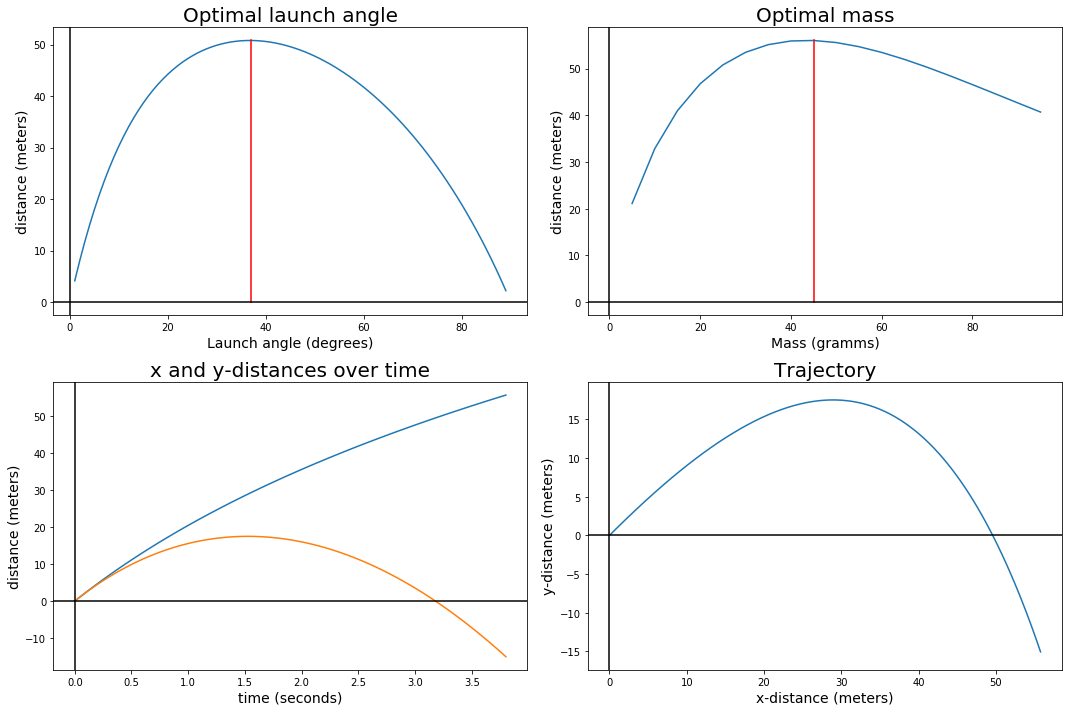

098/098 [🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀]



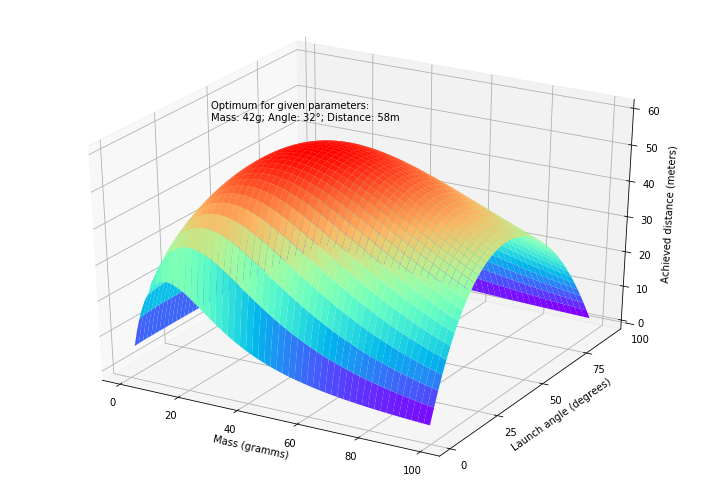

In [13]:
# when run as script, execute demo
if __name__ == '__main__':
    modulemode = False
    demo()
    plt.show()